# DAY 59

在之前的学习中，我们层层递进的介绍了时序模型的发展，从AR到MA到ARMA，再到ARIMA。本质就是把数据处理的操作和模型结合在一起了，实际上昨天提到的季节性差分也可以合并到模型中，让流程变得更加统一。

季节性差分用S来表示，所以这个模型叫做SARIMA模型

# 一、SARIMA模型



SARIMA (Seasonal AutoRegressive Integrated Moving Average)是标准ARIMA模型的扩展。它专门用于处理具有明显季节性模式的时间序列数据。

可以把SARIMA想象成一个“双核”的ARIMA模型：

1. 一个非季节性核心，用来处理数据的整体趋势。
2. 一个季节性核心，用来处理数据中的周期性模式。


## 1.1 SARIMA模型的参数

SARIMA模型由两组参数定义：(p,d,q) 和 (P,D,Q,m) 

ps：注意大小写

1. 非季节性部分: (p, d, q) 这里和之前arima一致
2. 季节性部分: (P, D, Q, m)，这是一套全新的参数 (P, D, Q, m)。它负责处理序列的长期、周期性的依赖关系。

标准写法 SARIMA(p, d, q)(P, D, Q)m

这里之所以m单独拿出来，为了在概念上强调 m 的独特性

m 是舞台，P,D,Q 是演员

m 定义了季节性的“舞台”有多大。它不是一个需要通过模型拟合来“学习”的阶数，而是数据本身固有的、预先定义的结构性属性。m可以理解为季节周期。

在分析数据之初，我们通过观察或业务常识就能确定m。看到月度数据，我们立刻知道m=12；看到季度数据，我们知道m=4。

m 告诉模型：“你要关注的周期性规律是每隔m个时间点重复一次的。” 它为季节性核心 (P, D, Q) 的所有运算提供了基准尺度。


(P, D, Q)季节性阶数，它们描述了在这个季节性尺度上，模型的具体行为。

- P: 在m的尺度上，需要看过去几个季节的自己？(y_{t-m}, y_{t-2m}, …)
- D: 在m的尺度上，需要做几次差分？(y_t - y_{t-m})
- Q: 在m的尺度上，需要看过去几个季节的误差？(error_{t-m}, error_{t-2m}, …)
这些阶数通常需要通过分析季节性差分后的ACF/PACF图来确定。


这里我们强调下（p，d，q）和（P，D，Q）的区别。差别在于它们看的不是上一个时间点，而是上一个季节的同一时间点。

普通差分 (d) 是 y_t - y_{t-1} (今天 - 昨天)。季节性差分 (D) 是 y_t - y_{t-m} (今年8月 - 去年8月)。

它的作用是消除季节性带来的增长趋势，让季节性数据变得平稳。如果用电量每年夏天都比上一年夏天高，D=1就能消除这个影响。



普通AR (p) 认为 y_t 和 y_{t-1}, y_{t-2}… 相关。季节性AR (P) 认为 y_t 和 y_{t-m}, y_{t-2m}… 相关。也就是说，模型认为今年8月的用电量和去年8月、前年8月的用电量有直接关系。




普通MA (q) 认为 y_t 的误差和 t-1, t-2 时刻的误差相关。季节性MA (Q) 认为 y_t 的误差和 t-m, t-2m 时刻的误差相关。也就是说，模型认为对今年8月的预测误差，可以根据去年8月、前年8月的预测误差来进行修正。

总结：季节性阶数是对比不同季节的同一时刻的差别。



## 1.2 SARIMA模型的理解

sarima不是单纯的对arima做了一次季节差分，而且做了季节性的一些其他特征捕捉：季节自回归P、季节移动平均Q。

SARIMA的完整工作流是这样的：

1. 季节性层面分析：模型首先利用 (P, D, Q)m 这一套完整的“季节性ARIMA”来处理数据。它进行季节性差分(D)，然后用季节性自回归(P)和季节性移动平均(Q)来解释季节性平稳后的数据中的模式。这个过程的输出是一个“季节性影响被剥离后”的残差序列。

2. 非季节性层面分析：接着，模型再将我们熟悉的 (p, d, q) 应用于第一步产生的残差序列上。它对这个序列进行普通差分(d)，然后用AR(p)和MA(q)来捕捉其中剩余的、短期的、非季节性的模式。

总结：SARIMA不是在ARIMA上打个补丁，而是构建了一个与非季节性部分 (p,d,q) 平行且完整的季节性分析系统 (P,D,Q)m。这两个系统协同工作，一个负责宏观的、周期性的规律，另一个负责微观的、短期的波动，最终结合成一个强大而全面的预测模型。

## 1.3 SARIMA实战

### 1.3.1 数据观察

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
# 显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 1. 加载数据
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)
df.columns = ['Passengers']

# 2. 划分训练集和测试集（保留最后12个月作为测试）
train_data = df.iloc[:-12]
test_data = df.iloc[-12:]

print("--- 训练集 ---")
print(train_data.tail()) # 观察训练集最后5行
print("\n--- 测试集 ---")
print(test_data.head()) # 观察测试集前5行

--- 训练集 ---
            Passengers
Month                 
1959-08-01         559
1959-09-01         463
1959-10-01         407
1959-11-01         362
1959-12-01         405

--- 测试集 ---
            Passengers
Month                 
1960-01-01         417
1960-02-01         391
1960-03-01         419
1960-04-01         461
1960-05-01         472


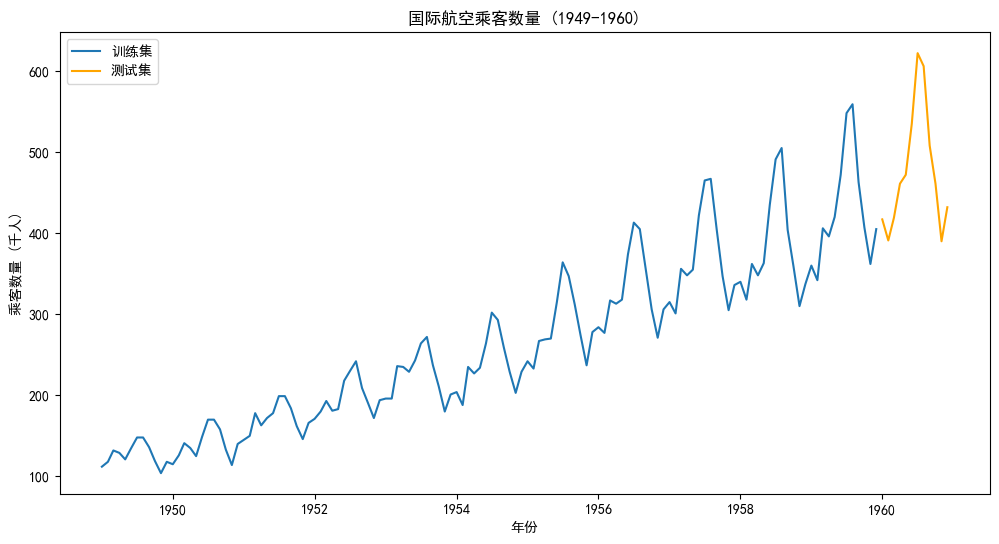

In [2]:
# 3. 可视化原始数据
plt.figure(figsize=(12, 6))
plt.plot(train_data['Passengers'], label='训练集')
plt.plot(test_data['Passengers'], label='测试集', color='orange')
plt.title('国际航空乘客数量 (1949-1960)')
plt.xlabel('年份')
plt.ylabel('乘客数量 (千人)')
plt.legend()
plt.show()

从图中可以清晰地看到两个特征：

1. 长期趋势（Trend）: 乘客数量随着时间推移，呈现明显的上升趋势。
2. 季节性（Seasonality）: 数据中存在以年为周期的规律性波动，每年夏季是出行高峰。

结论：数据非平稳，且具有强烈的季节性。这正是SARIMA模型的用武之地！

### 1.3.2 尝试差分阶数

然后，我们需要确定SARIMA模型参数 (p,d,q)(P,D,Q)m

1. 确定季节周期 m
数据是月度的，季节性模式是年度的。因此，季节性周期 m = 12。

2. 确定差分阶数 d 和 D
我们的目标是通过差分使数据平稳。通常先进行季节性差分，再看是否需要普通差分。

- 季节性差分 D: 由于有明显的季节性，我们先尝试 D=1。
- 普通差分 d: 季节性差分后，可能还存在长期趋势，我们再尝试 d=1。


让我们进行 d=1, D=1 的双重差分，并用ADF检验来验证平稳性。

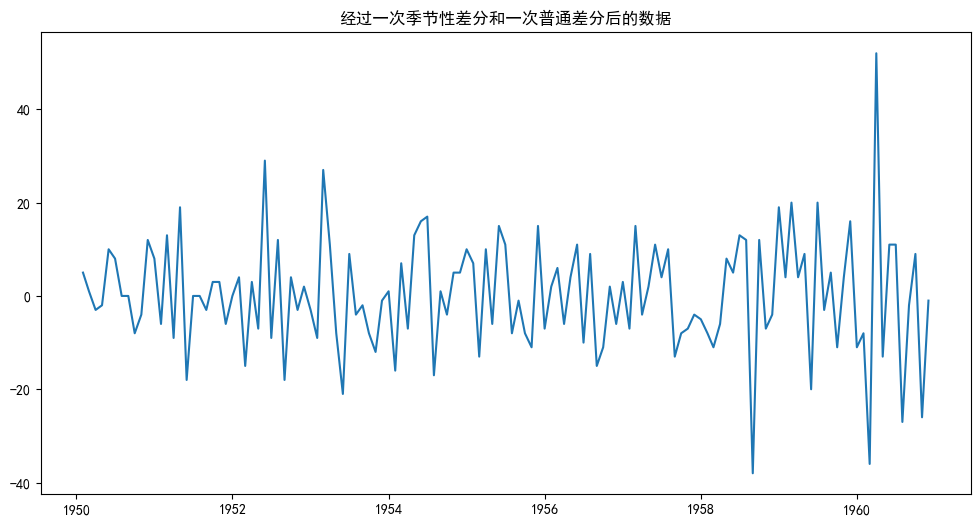

ADF Statistic: -15.595618083746334
p-value: 1.8565116001234705e-28


In [3]:
# 进行季节性差分 (D=1, m=12)
seasonal_diff = df['Passengers'].diff(12).dropna()
# 再进行普通差分 (d=1)
seasonal_and_regular_diff = seasonal_diff.diff(1).dropna()

# 绘制差分后的数据
plt.figure(figsize=(12, 6))
plt.plot(seasonal_and_regular_diff)
plt.title('经过一次季节性差分和一次普通差分后的数据')
plt.show()

# ADF检验
result = adfuller(seasonal_and_regular_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}') # p-value越小，越说明数据平稳


差分后的图像看起来像白噪声，围绕0上下波动，没有明显趋势和季节性。

ADF检验的 p-value 远小于0.05，强烈拒绝了“数据非平稳”的原假设。

结论: d=1, D=1 是一个很好的选择。

### 1.3.3 可视化确定其余参数

接下来确定AR/MA阶数 (p,q) 和 (P,Q)

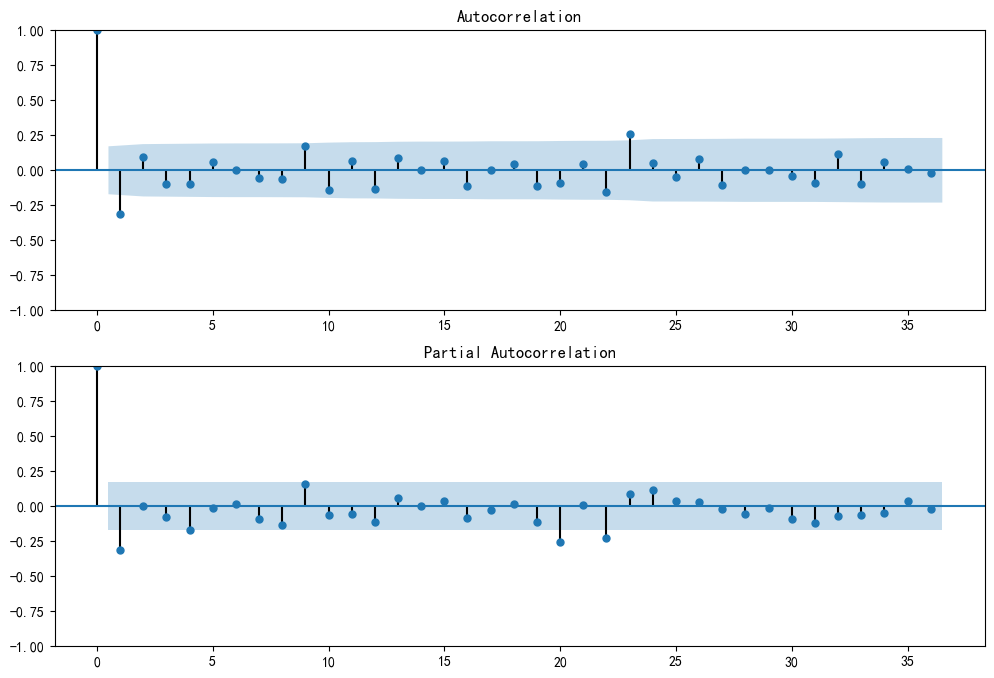

In [4]:
# 绘制ACF和PACF图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(seasonal_and_regular_diff, lags=36, ax=ax1) # 绘制36个时间点
plot_pacf(seasonal_and_regular_diff, lags=36, ax=ax2)
plt.show()

这两张图是基于对原始数据进行了一次普通差分(d=1)和一次季节性差分(D=1, m=12)之后得到的。蓝色的阴影区域是置信区间，任何超出这个区域的“尖峰”都被认为是统计上显著的。

需要借助之前学到的截尾、拖尾来判断，但是太难记了，直接超参数搜索吧。我们昨天才说了好的模型AIC比较低。

### 1.3.4 超参数搜索

In [5]:
from pmdarima import auto_arima # 一个方便的自动调参库
# 使用auto_arima自动寻找最优模型
# 我们告诉它d=1, D=1, m=12是固定的，让它去寻找p,q,P,Q的最优组合
# 默认使用AIC作为评估标准
auto_model = auto_arima(train_data['Passengers'],
                        start_p=0, start_q=0,
                        max_p=2, max_q=2,
                        m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=905.419, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.967, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.823 seconds
                                     SARIMAX Results                                      


直接看结果：Best model:  ARIMA(1,1,0)(0,1,0)[12]

### 1.3.5 模型诊断

昨天说了模型通过输出的结果诊断表来诊断，今天补充一个模型诊断图，方便未来写论文可视化。

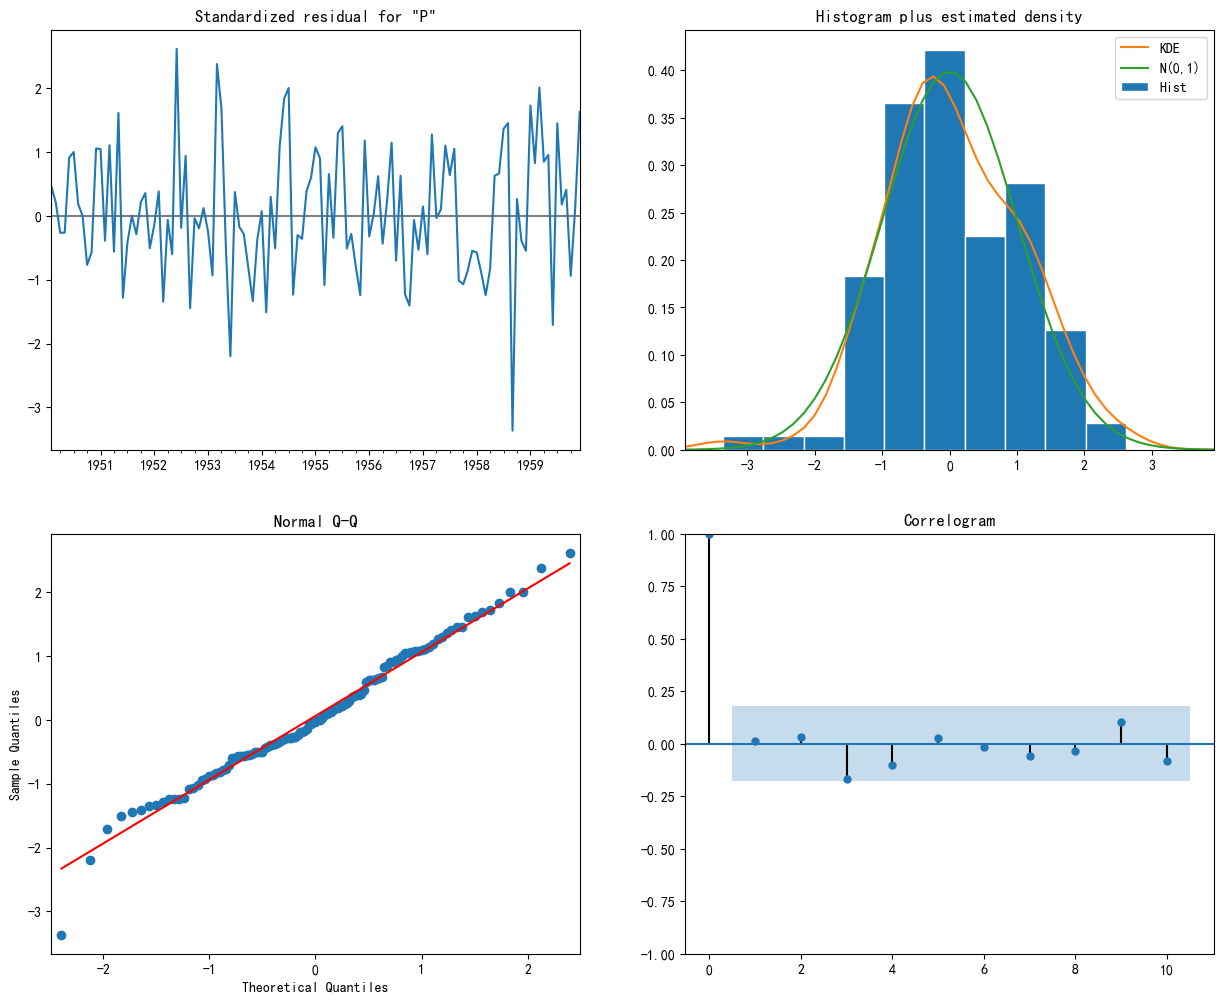

In [6]:
# 从auto_arima的结果中获取最优参数

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

# 拟合模型
model = SARIMAX(train_data['Passengers'],
                order=best_order,
                seasonal_order=best_seasonal_order)
results = model.fit(disp=False)

# 打印模型诊断图
results.plot_diagnostics(figsize=(15, 12))
plt.show()


好的，这是模型诊断图，它的目的是检验我们拟合的SARIMA模型是否“好”。一个好的模型应该能充分提取数据中的所有可预测信息，剩下的残差（residuals）应该看起来像随机的、无规律的白噪声。



这张图从四个不同的角度来验证残差是否满足白噪声的假设。我们来逐一解读：

1. 左上角：Standardized residual (标准化残差图)
看什么？: 这张图展示了随着时间变化的残差值。我们希望看到的是没有明显模式的随机波动。

图中表现:残差基本在0值上下波动，没有明显的上升或下降趋势。
波动幅度（方差）看起来也比较稳定，没有出现某一时期波动特别大或特别小的情况。
有一个点在1958年底附近异常低（接近-3.5），这可能是一个异常值，但整体来看，没有破坏总体的随机性。
结论: 通过。残差序列看起来没有自相关性和异方差性，满足了模型假设。（严格意义要通过检验的，不过差不多就行）



2.  右上角：Histogram plus estimated density (直方图+核密度估计)
这张图检验残差是否服从正态分布。

蓝色柱状图 (Hist): 残差的分布直方图。

橙色线 (KDE): 核密度估计线，是根据残差数据画出的平滑分布曲线。

绿色线 (N(0,1)): 标准正态分布（均值为0，方差为1）的理论曲线。

图中表现: 橙色的KDE曲线与绿色的标准正态分布曲线非常接近，蓝色柱状图的形状也大致呈钟形。
结论: 通过。残差的分布与正态分布非常吻合，这符合白噪声的假设之一。


3. 左下角：Normal Q-Q (正态Q-Q图)
这是另一种检验正态分布的强大工具。如果数据服从正态分布，那么图中的蓝色散点应该紧密地排列在红色的对角线上。

图中表现:绝大多数的点都非常完美地落在了红线上。只有在尾部（左下角和右上角）有少数几个点略微偏离，这对应了直方图中略厚的尾部和残差图中的个别异常值。

结论:  通过。Q-Q图强有力地证明了残差序列基本服从正态分布。


4. 右下角：Correlogram (相关图 / ACF图)
这是最重要的图之一。它展示了残差序列的自相关性。如果模型已经提取了所有信息，那么残差之间不应该再有任何相关性。也就是说，所有的自相关系数（柱子）都应该落在蓝色的置信区间内（除了lag=0，它自己和自己的相关性永远是1）。

图中表现:除了 lag=0 那个必然为1的柱子外，几乎所有其他 lag 的柱子都在蓝色阴影区域内。可能在lag=3或lag=9处有柱子稍微触碰或略微超出边界，但这在统计上是可能发生的（在95%的置信度下，每20个点就可能有1个因随机性而超出），不构成严重问题。
结论: 通过。残差序列中没有遗留显著的自相关性。这说明我们的SARIMA模型已经成功捕捉了原始数据中的时间依赖结构。


所以模型非常好。这四张诊断图从不同角度反应模型的残差表现出了理想的白噪声特性：

- 独立 (ACF图显示无自相关)
- 同分布 (残差图显示方差稳定)
- 服从正态分布 (直方图和Q-Q图证明)

这给了我们很强的信心，可以使用这个模型进行下一步的预测，并且相信预测结果是可靠的。

### 1.3.6 结果预测

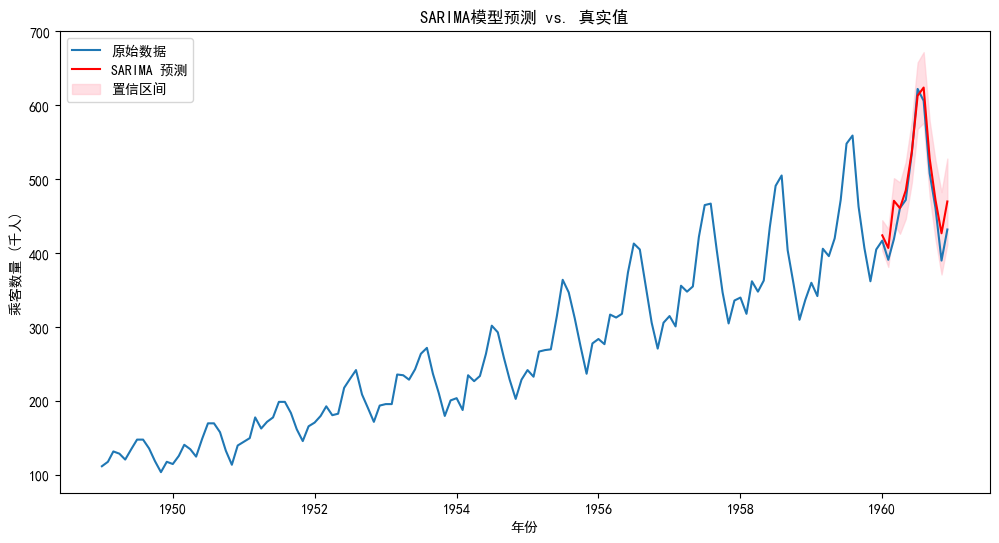

In [7]:
# 预测未来12个点
predictions = results.get_prediction(start=test_data.index[0], end=test_data.index[-1])
pred_mean = predictions.predicted_mean # 预测均值
pred_ci = predictions.conf_int() # 预测的置信区间

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='原始数据')
plt.plot(pred_mean, label='SARIMA 预测', color='red')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.5, label='置信区间')
plt.title('SARIMA模型预测 vs. 真实值')
plt.xlabel('年份')
plt.ylabel('乘客数量 (千人)')
plt.legend()
plt.show()


红色的预测线与原始数据在测试集部分的走势几乎完美重合！说明它不仅预测了整体的上升趋势，还精准地捕捉到了每一个季节性的波峰和波谷。

你会看到很多时序论文中，所说的捕捉到波峰和波谷，本质上就是说准确预测季节性。非常多的时序数据都存在季节性。

# 二、 多变量时序任务的理解

## 2.1 多变量数据

我们之前处理的航空乘客数据就是单变量的。它的特点是：在每个时间点，我们只记录一个值。

例子：[时间1: 乘客数A], [时间2: 乘客数B], [时间3: 乘客数C], ...

多变量时间序列 (Multivariate Time Series)
它的特点是：在每个时间点，我们同时记录多个变量的值。这些变量通常是相互关联、相互影响的。

想象一下医院里病人的监护仪。
    1. 单变量分析：只看病人的体温随时间的变化。
    2. 多变量分析：同时记录病人的体温、心率、血压、呼吸频率随时间的变化。显然，这些指标是相互关联的，综合分析它们能更准确地判断病人的健康状况。

单变量：y_t 是一个标量（一个数字）。

多变量：y_t 是一个向量（一组数字）。

那如果只是想预测一个变量呢？

我们把这个想要预测的变量叫做目标变量（内生变量），其他变量叫做外部变量（外生变量）。

也就是说，这些外部变量被视为“特征”，而目标变量被称为“标签”。

## 2.2 常见的多变量预测模型

多变量时序预测模型可以分为三大类：

1. 经典统计模型 (Classical Statistical Models)：基于严格的统计假设，模型结构清晰，解释性强。
2. 机器学习模型 (Machine Learning Models)：将时序问题转化为监督学习问题，灵活性高，能处理复杂关系。--之前已经简单介绍过单变量用机器学习预测，效果很差，主要是模型的算法导致的。
3. 深度学习模型 (Deep Learning Models)：专门为序列数据设计，能自动学习复杂的时序模式和长期依赖。

### 2.2.1 经典统计模型

SARIMAX (Seasonal ARIMA with eXogenous variables)

SARIMAX 模型中的“X”就代表“eXogenous”，即“外生变量”。

如果说SARIMA是“双核”模型，那么SARIMAX可以看作是一个“三核”模型：

- 非季节性核心 (ARIMA部分): (p, d, q)，负责捕捉数据的长期趋势和非季节性自相关性。
- 季节性核心 (Seasonal部分): (P, D, Q, m)，负责处理数据的周期性模式。
- 外部影响核心 (eXogenous部分): X，负责量化一个或多个外部变量对目标变量的影响。

本质上，SARIMAX = SARIMA + 线性回归

模型首先像SARIMA一样，分析目标序列 y 自身的历史模式（趋势、季节性等）。
然后，它同时建立一个类似线性回归的模型，来评估外生变量 X 是如何影响 y 的。
最终的预测结果是这两部分作用的结合。

ARIMA模型: y_t = f(过去的y值, 过去的误差)

SARIMAX模型: y_t = f(过去的y值, 过去的误差) + β * x_t

这里的 y_t 是我们想预测的目标变量在时间 t 的值，x_t 是外生变量在时间 t 的值，而 β 是一个系数，表示 x_t 对 y_t 的影响程度。如果 β 为正，说明 x 和 y 是正相关；如果为负，则为负相关。



- 优点:解释性极强，每个外生变量的系数β意义明确。完美融入了季节性处理。
- 缺点:严格的单向因果假设：y不能反过来影响X。预测未来时，必须提供未来的X值，这是最大的实践障碍。适用场景: 当因果关系清晰且单向时（如天气影响销量），且未来的X是已知的或可预测的。

实际上这是一个很高的要求：
1. 单向因果假设，这要求了了数据含义相对简单，不存在循环依赖。
2. 要求未来的x可以预测，这说明未来的x和过去的x关系必须简单，否则很难得到未来的信息，比如特征是周几，今天是周一，那么未来明天必定是周二。

实际上现实中，很多数据非常复杂，特征存在循环依赖，且不可预测。一些好的解决方案如下：
1. 解决循环依赖问题，搞清楚因果关系，这里涉及到了因果分析框架，希望未来有机会和大家说。因果分析+机器学习 乱杀
2. 未来的特征不好获得，只有简单的问题才能满足

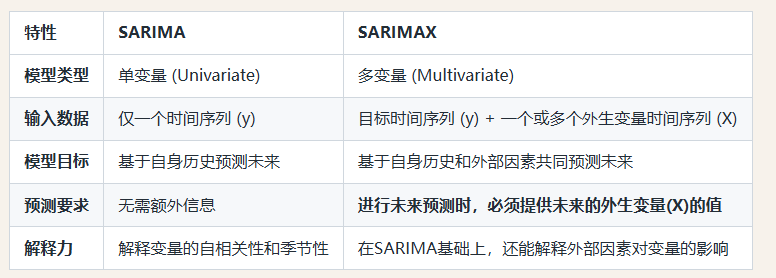

这里我们需要介绍下因果关系，之前大家接触的机器学习任务不考虑因果关系，他只关注特征和标签的相关关系。--这里浅浅的为未来我们可能提及的因果推断埋下伏笔

然而，相关不等于因果，比如 冰淇淋的销量与溺水死亡人数呈正相关。但这并不意味着吃冰淇淋会导致溺水。因为这两者都与一个潜在的第三方因素——季节（天气炎热）——有关。炎热的天气既促使人们购买冰淇淋，也使更多人去游泳，从而增加了溺水的风险。

机器学习的解释性方法，如shap是源自于博弈论的原理，并不考虑因果，所以得出的结论可能实际意义有误。









现实中的双向依赖（循环依赖）比比皆是，比如：
- 广告投入 和 销售额：广告投入（X）能提升销售额（y），但反过来，销售额的增长（y）可能会让公司有更多预算，从而增加广告投入（X）。
- 利率 和 通货膨胀：央行提高利率（X）是为了抑制通货膨胀（y），但通货膨胀率（y）本身就是央行调整利率（X）的最重要依据。

在这种场景下，强行将一个变量设为外生变量（X），另一个设为目标变量（y）是不合适的。

由于sarimax的单向因果关系，所以为了解决循环依赖这种问题，经典时序统计模型VAR 模型就是为了解决这个问题而生的。

VAR 模型不再区分“内生（目标）”和“外生（特征）”变量。它把系统中的每一个变量都看作是内生变量，相互影响，相互依赖。

核心思想： 系统中的每个变量，都可以用系统内所有变量的过去值来预测。

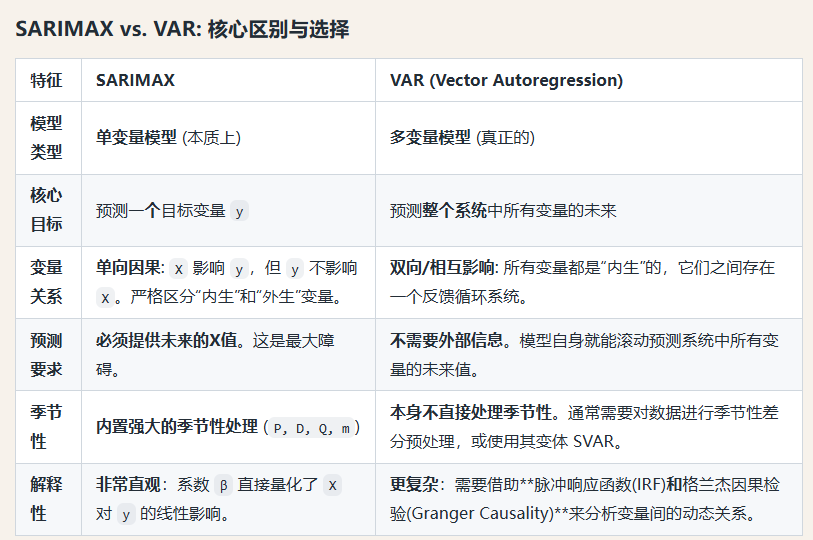

### 2.2.2 机器学习模型

这类方法通过滑动窗口技术，将时序问题转化为表格化的监督学习问题。

基于树的模型 (XGBoost, LightGBM, Random Forest)
- 核心思想: 用滞后值（y_{t-1}, y_{t-2}…）和其他变量（x1_{t-1}, x2_t…）作为特征，来预测y_t。
- 如何工作:创建大量的滞后特征、窗口统计特征（如过去7天的平均值、标准差）、时间特征（星期几、月份）。
- 将所有变量（无论内外生）都看作是特征。训练一个强大的梯度提升树模型。
- 优点:性能卓越，在很多Kaggle时序竞赛中胜出。能自动捕捉非线性和复杂的交互关系。对特征的类型和规模不敏感，无需平稳性假设。

但是我们之前说了，如果你能够对数据加工的更好，当然会让结果更好，期待模型自己发觉规律，也要搭配好的特征工程。所以在很多论文中可以看到如下思路：

sarima作为特征提取器，预测趋势、季节性，然后剩下的残差用XGBoost或者LightGBM进行预测。这样会大大加大准确率。

因为统计模型对于数据量的要求相对较低，而机器学习深度学习需要大量的数据驱动，这个时候让统计模型提取出来这些线性部分，然后让非线性部分交给深度学习模型来做，会大大加大预测效果。

### 2.2.3 深度学习模型

统计学模型的使用，需要严格的假设检验过程，使用深度学习模型（如LSTM、GRU、Transformer）可以让你避免对数据进行这些“繁琐”的假设检验。

它没有预设的专用工具，而是拥有一个极其强大的、通用的学习引擎和海量的传感器（神经网络）。你直接把一整根原木（原始数据）给它，它会自己通过观察和学习，理解这根木头的纹理、弯曲、湿度（即趋势、季节性、自相关性等复杂模式），并直接学会如何切割它来完成任务。------深度学习是“数据驱动”的：它是一个“万能函数拟合器”。理论上，只要有足够多的数据和合适的网络结构，它可以拟合出任意复杂的函数关系。它不关心数据是否平稳，而是直接从数据中学习这些“不平稳”的模式本身。趋势和季节性在它看来，不是需要消除的“问题”，而是需要学习的“特征”。



同理，好的特征提取仍然可以帮助深度学习提取特征，同时也可以给其参数提供建议。

ACF/PACF图帮你选择sequence_length：
ACF/PACF图告诉你一个值和它过去多少个值有关系。比如，如果ACF图显示季节性周期是12，那么你在设置LSTM的“回看窗口”(sequence_length)时，把它设为12或其倍数，可能会是一个非常好的起点。

平稳性检验帮你做特征工程：
如果你通过检验发现数据有强烈的趋势，即使LSTM能学，你也可以通过一些简单的处理来“帮助”它学得更好、更快。比如：

差分：对数据做一次差分，然后让LSTM去预测这个“变化量”，最后再把结果加回去。这常常能让模型训练更稳定。
添加时间特征：把“月份”、“星期几”作为额外的特征输入给模型，等于明确地告诉模型：“注意，这里面有周期性规律！”，帮助它更快地捕捉到季节性。

先让“结构工程师”（分解模型）把宏观的、确定的趋势和季节性部分拿走。
然后，把剩下的、更接近平稳的、但仍然包含一些微弱信息的“残差”，交给“精装修师傅”（ARIMA）去处理。
最后，将两部分的工作成果合起来，得到最终的精美成品（预测结果）。

```
预测流程：
原始数据 → [分解] → 趋势(T) + 季节性(S) + 残差(R)
↓
[分别预测]
↓
预测的趋势(T_hat) + 预测的季节性(S_hat) + 预测的残差(R_hat)
↓
[相加合并]
↓
最终的预测值
```

# 三、 课程收尾总结

## 3.1 心得总结

至此，我们训练营的内容到这里就宣告结束了，知识密度基本覆盖了之前复试课的90%的知识点（NLP内容、RNN变体实在来不及说了），day60将会是自由学习（复习日），打卡训练营更新到现在，确实不容易，也没想到能完成工作量这么庞大的一次积累，也很感谢能够坚持到这里的各位，说一些打卡训练营的一些心得。

1. 在这个训练营中其实我的个人能力也是提升的，这是实话，因为过去在科研中，很多问题我知道如何做的，但是我并没有体系化的思考过这样做的原因，接着这次机会也让我把整个体系给串起来，个人觉得逻辑是完全闭环，该重点交代的都交代了，不至于出现知识点断层的情况。这也是为什么你们能看到很多人做的感觉很高大上，但是仔细去研究发现他甚至有一些逻辑上的错误，这是因为他没有扎实的基础，对很多问题在基础的认识上就有问题。

2. 学习是需要持续性的，之前大家肯定看到很多所谓的速成xxx，但是实际你思考下，哪怕是一个小的专题，比如时序预测的小demo，粗略估计没有十多天的内容你都没法理解整个闭环的流程，比如为什么和arima做对比？为什么用arima做特征工程？很多知识背后有很多隐知识在里面，只有实践和思考才能真正理解这些问题，这里只能堆时间，而且只有持续的堆时间才不至于下次重来------工科就是一个堆时间的科目，任何的短期捷径到后面肯定要付出双倍的时间。



## 3.2 一些后续的交代

篇幅和设备限制，有一些任务必须搭配视频才能讲清楚，比如多个文件协同的任务等，会在科研班的后续提到，科研班的人工智能进阶部分也会沿用目前的这个体系化的形式更新

代码+讲义（体系化梳理）+视频，这样每个大的知识点拆成多个小知识点的方式会极大提高输出的知识密度和逻辑闭环的可能性。

本期训练营之前的知识点还有一些由于篇幅问题无法交代，我会在科研班中交代，这里我列举出来一些和目前内容接轨的知识点，如果没有在科研班的同学建议大家自行学习：

1. 服务器的远程使用
2. py文件训练时命令行的参数（文件中定义main（args），在通过parser.add_argument
即可使用）
3. tansfomer架构的代码解读
4. 张量维度变换的总结
5. git工具的使用
6. optuna超参数优化框架



最后祝大家前程似锦！读研顺利！